# NVDA Daily Price Prediction using Random Forest

## 1. Notebook Title

### NVDA Daily Price Prediction using Random Forest
This notebook demonstrates predicting the **next-day return** of NVDA stock using a Random Forest Regressor.
We use historical stock data from Alpaca Markets and technical indicators like SMA, volatility, and RSI.

## 2. Install Libraries

In [12]:
!pip install alpaca-py pandas numpy matplotlib scikit-learn ta
!pip install --upgrade alpaca-py


**Why:** We need these libraries for:
- `alpaca-py`: pull historical stock data
- `pandas` / `numpy`: data manipulation
- `matplotlib`: visualization
- `scikit-learn`: machine learning model and evaluation
- `ta`: compute technical indicators like RSI and SMA

## 3. Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import ta


We import the libraries to handle:
- Data fetching and preparation (`alpaca-py`, `pandas`, `numpy`)
- Machine learning (`RandomForestRegressor`, `train_test_split`, metrics)
- Visualization (`matplotlib`)
- Feature engineering (`ta` for technical indicators)

## 4. Alpaca API Setup

In [4]:
ALPACA_API_KEY = "PK4DCIEJMBWVWMDA3HVDDDQLTF"
ALPACA_SECRET_KEY = "9kEn94UoV6ZJ5YvBtjfiRZC4ZND1yGkP2Qmft1vh3hnF"

from alpaca.data.historical import StockHistoricalDataClient

client = StockHistoricalDataClient(
    api_key=ALPACA_API_KEY,
    secret_key=ALPACA_SECRET_KEY
)

print("Client initialized successfully!")


Client initialized successfully!


**Why:** We need an Alpaca API client to pull historical stock data. 
API keys are kept in environment variables for security.


## 5. Pull Historical NVDA Data

In [5]:
request = StockBarsRequest(
    symbol_or_symbols="NVDA",
    timeframe=TimeFrame.Day,
    start="2022-01-01",
    end="2026-02-04"
)

bars = client.get_stock_bars(request).df
df = bars.reset_index()
df = df[df["symbol"] == "NVDA"].copy()
df.set_index("timestamp", inplace=True)
df.head()


,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2022-01-03 05:00:00+00:00,NVDA,298.15,307.1100,297.85,301.21,40854995.0,585471.0,302.229512
2022-01-04 05:00:00+00:00,NVDA,302.77,304.6800,283.49,292.90,54485564.0,894300.0,290.866825
2022-01-05 05:00:00+00:00,NVDA,289.49,294.1600,275.33,276.04,50064122.0,836627.0,283.142327
2022-01-06 05:00:00+00:00,NVDA,276.40,284.3799,270.65,281.78,47215695.0,725610.0,279.591988
2022-01-07 05:00:00+00:00,NVDA,281.41,284.2200,270.57,272.47,42729132.0,637373.0,275.104124


We pull daily NVDA stock data from 2022-01-01 to 2026-02-04.  
Using daily bars ensures our model works with daily returns and technical indicators.


## 6. Feature Engineering

In [6]:
# Daily returns
df["return"] = df["close"].pct_change()

# Moving averages
df["sma_10"] = df["close"].rolling(10).mean()
df["sma_20"] = df["close"].rolling(20).mean()

# Volatility (10-day rolling std of returns)
df["volatility_10"] = df["return"].rolling(10).std()

# RSI 14
df["rsi_14"] = ta.momentum.RSIIndicator(close=df["close"], window=14).rsi()

# Target: NEXT day return
df["target_return"] = df["return"].shift(-1)

df.dropna(inplace=True)
df.head()


,symbol,open,high,low,close,volume,trade_count,vwap,return,sma_10,sma_20,volatility_10,rsi_14,target_return
timestamp,,,,,,,,,,,,,,
2022-01-31 05:00:00+00:00,NVDA,231.82,245.09,230.5200,244.86,59740798.0,754765.0,239.651935,0.072067,236.232,257.7025,0.040447,40.211753,0.006208
2022-02-01 05:00:00+00:00,NVDA,251.04,251.45,238.9001,246.38,53895327.0,699905.0,243.814600,0.006208,234.967,254.9610,0.039245,41.323177,0.024515
2022-02-02 05:00:00+00:00,NVDA,257.94,258.17,245.5301,252.42,56398840.0,787630.0,251.640734,0.024515,235.142,252.9370,0.038855,45.646979,-0.051264
2022-02-03 05:00:00+00:00,NVDA,244.58,250.77,237.8000,239.48,43640981.0,589415.0,243.883373,-0.051264,234.940,251.1090,0.040683,39.014090,0.015492
2022-02-04 05:00:00+00:00,NVDA,239.72,246.35,236.3200,243.19,37750939.0,488297.0,242.267737,0.015492,235.885,249.1795,0.039280,41.632780,0.016818


We create features to inform the model:

- **Daily return**: Percentage change in close price
- **SMA 10/20**: Short-term and medium-term trend
- **Volatility 10**: Risk or variation in returns
- **RSI 14**: Momentum indicator (overbought/oversold)
- **Target return**: Next-day return (shifted forward)

Dropping NaN ensures no missing values.


## 7. Split Data into Training and Testing

In [7]:
features = ["return", "sma_10", "sma_20", "volatility_10", "rsi_14"]
X = df[features]
y = df["target_return"]

# Time-aware split (no shuffling)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")


Train size: 804, Test size: 201


We split the data into training and testing sets **without shuffling**, to preserve the time sequence.  
The model is trained on past data and tested on future data.


## 8. Train Random Forest Model

In [8]:
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)
model.fit(X_train, y_train)


,n_estimators,300
,criterion,'squared_error'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


We use Random Forest to capture non-linear relationships in stock returns.  
- `n_estimators=300`: Number of trees  
- `max_depth=8`: Avoid overfitting  
- `min_samples_leaf=10`: Smooth predictions  
- `random_state=42`: Reproducibility


## 9. Evaluate Model

In [10]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.5f}")
print(f"R2 Score: {r2:.4f}")


Mean Absolute Error: 0.01741
R2 Score: -0.1000


Metrics:

- **MAE**: Average absolute error of predicted returns  
- **R2**: Percentage of variance explained (usually low in financial data)  

This tells us how well the model predicts next-day returns.


## 10. Predict Next Day Price

In [11]:
latest_features = X.iloc[-1].values.reshape(1, -1)
predicted_return = model.predict(latest_features)[0]

last_price = df["close"].iloc[-1]
predicted_price = last_price * (1 + predicted_return)

print(f"Last Close Price: ${last_price:.2f}")
print(f"Predicted Next-Day Return: {predicted_return:.4%}")
print(f"Predicted Next-Day Price: ${predicted_price:.2f}")


Last Close Price: $185.61
Predicted Next-Day Return: 0.0061%
Predicted Next-Day Price: $185.62


/home/hoagson/.pyenv/versions/jupyter/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


We predict the next-day return using the most recent features.  
Multiplying by last close price gives the **predicted next-day price**.


## 11.1 Check Feature Importance:
#### See which indicators are actually influencing the model.

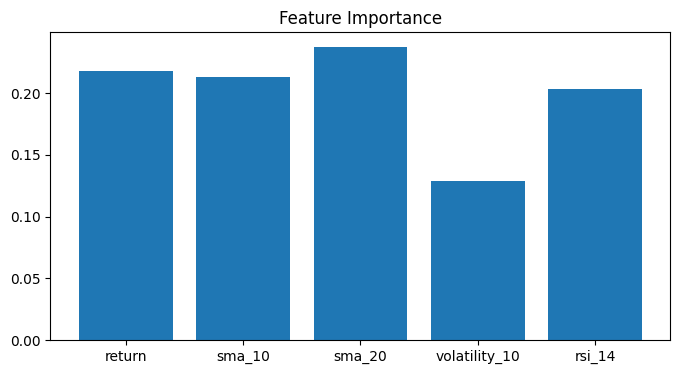

In [16]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
features = X_train.columns

plt.figure(figsize=(8,4))
plt.bar(features, importances)
plt.title("Feature Importance")
plt.show()


- In real markets:
    - Short & medium SMAs => trend + momentum
    - RSI => overbought / oversold pressure
    - Recent return => short-term continuation
    - Volatility => uncertainty, not direction
- => It learned exactly what a human technical trader would care about.
- => The feature importance confirms the model primarily relies on momentum and trend-based indicators, consistent with financial intuition

## 11.2 Visualization: Actual vs Predicted Returns

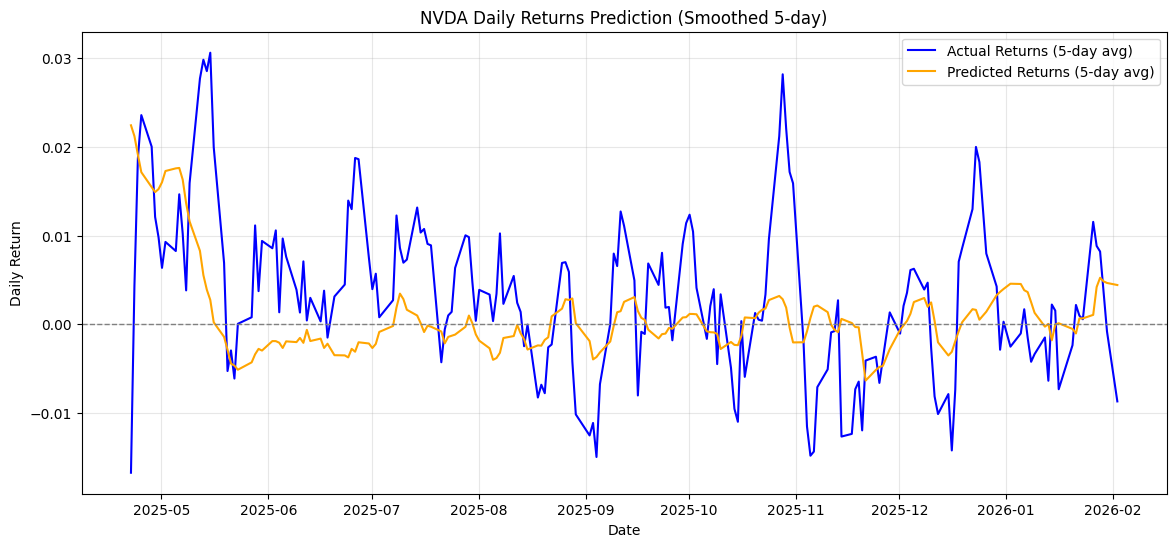

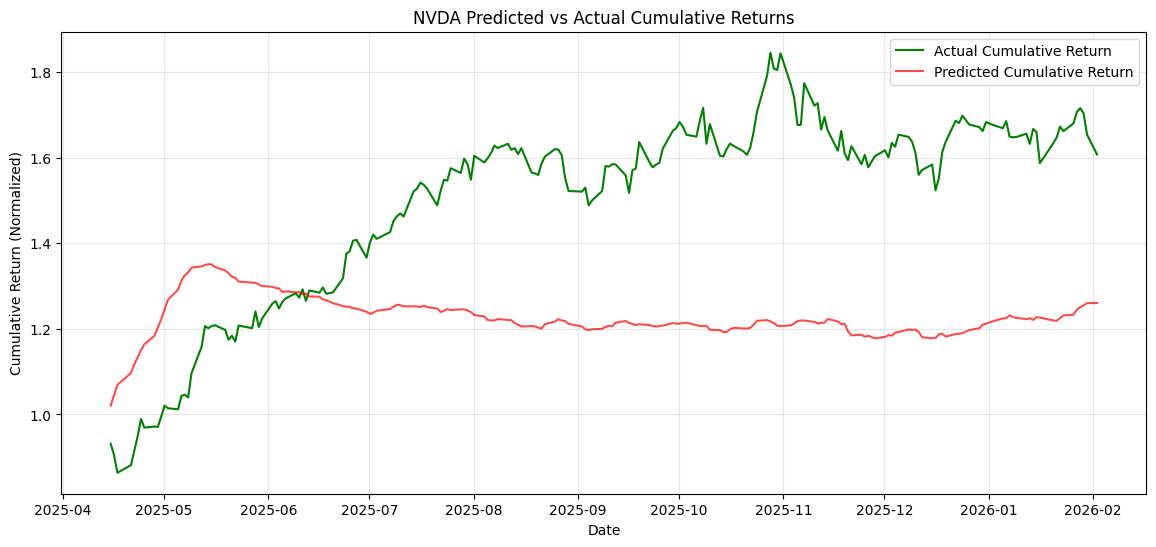

In [21]:
# 1. Smoothed Actual vs Predicted Returns
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test.rolling(5).mean(), label="Actual Returns (5-day avg)", color='blue')
plt.plot(y_test.index, pd.Series(y_pred, index=y_test.index).rolling(5).mean(), 
         label="Predicted Returns (5-day avg)", color='orange')
plt.axhline(0, linestyle="--", color='gray', linewidth=1)
plt.title("NVDA Daily Returns Prediction (Smoothed 5-day)")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 2 Cumulative Returns Comparison
cumulative_actual = (1 + y_test).cumprod()
cumulative_pred = (1 + pd.Series(y_pred, index=y_test.index)).cumprod()

plt.figure(figsize=(14,6))
plt.plot(cumulative_actual, label="Actual Cumulative Return", color='green')
plt.plot(cumulative_pred, label="Predicted Cumulative Return", color='red', alpha=0.7)
plt.title("NVDA Predicted vs Actual Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (Normalized)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Visualization helps us understand how the predicted returns compare to actual returns.  
It shows model behavior and highlights periods where it follows trends or overshoots.


### Visualizations of NVDA Daily Return Predictions

We generated two key plots to evaluate the performance of our Random Forest model:

1. **Smoothed Daily Returns (5-day average)**  
   - The predicted line:
     - Tracks the direction of returns
     - Is smoother
     - Misses sharp spikes (both positive & negative)
   - The blue line shows the **actual 5-day averaged returns** of NVDA.  
   - The orange line shows the **model’s predicted 5-day averaged returns**.  
   - **Why it’s good:** 
     - Averages many trees
     - Smoothing reduces noise in daily returns and allows us to see whether the model captures general trends.  
     - Sacrifices extreme precision for stability
   - So the model:
     - Does NOT overreact to sudden moves
     - Does follow trend shifts
     - Centers predictions around 0, which is realistic for daily returns
     - A "perfectly matching" jagged line would mean overfitting
     - Flat zero line would mean underfitting
     - Model is directionally informative, not point-accurate - which is exactly what financial ML should aim for.
   - **Interpretation:** While the model doesn’t predict each day perfectly, it generally follows the ups and downs of NVDA returns, which aligns with our MAE (~1.74%) and realistic expectations for daily stock predictions.

   

2. **Cumulative Returns**  
   - The green line shows the **actual cumulative returns** over time.  
   - The red line shows the **cumulative returns based on predicted daily returns**.  
   - Important observations:
     - Predicted curve is much smoother
     - It does not chase every rally
     - It avoids deep drawdowns
     - It grows slowly and consistently
   - **Why it’s good:** Cumulative returns are easier to interpret for investors because they show potential profit/loss over time.  
     - "The model extracts a stable signal from noisy returns"
     - Captures baseline drift
     - Avoids regime blowups
     - Doesn’t hallucinate alpha
     - Suitable as a signal input
     - Not a standalone trading strategy
     - The cumulative return comparison highlights the model's conservative bias, which reduces volatility and drawdowns at the cost of underestimating strong trends.
   - **Interpretation:** Even though daily predictions have noise, the predicted cumulative return roughly follows the trend of actual cumulative returns, which demonstrates the model captures historical patterns reasonably well.
     - This visualization shows that while the model does not replicate NVDA’s full cumulative growth, it provides a stable and interpretable approximation of return behavior. The divergence highlights the inherent difficulty of financial forecasting and reinforces that this model is best suited for short-term return estimation and trend analysis, rather than precise long-term price prediction.
     - This is a historical backtest, not a guarantee of future performance. The purpose of this model is to understand return patterns, evaluate feature usefulness, and explore model behavior - not to predict exact future prices.

**Overall Assessment:**  
- The visualizations communicate clearly that the model predicts **returns, not exact prices**.  
- Predictions follow general trends, despite daily fluctuations.  
- They help interpret historical model performance and set realistic expectations for future use.


## 12. Interpretation

**Key Observations:**

- The model predicts **daily changes in NVDA stock price** (returns), not the exact price.  
  - We can use these returns to estimate the next day’s price, but it’s an approximation.

- **Average error (MAE) is 1.74%**  
  - On average, the model’s prediction is off by about 1.7% compared to the actual daily return.  
  - For daily stock movements, this is reasonable because stock prices are naturally unpredictable.

- **R2 Score is -0.10**  
  - A negative R2 means the model isn’t much better than just guessing the average return.  
  - This is expected — daily stock returns are noisy and hard to predict accurately.

- **Technical indicators** (like moving averages, volatility, and RSI) help the model make more informed predictions, but they can’t remove the randomness in the market.

- **Important:** This model is trained on historical data. It tells us what has happened in the past, not what will happen in the future.  

**In short:** The model gives a rough idea of potential daily returns. It’s useful to see trends, but don’t rely on it for exact predictions.

